In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import class_weight
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import mixed_precision
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# Define constants
IMG_SIZE = 224  # Image size (height and width)
BATCHSIZE = 32  # Batch size
EPOCHS = 100
data_dir = "data" 
l2_lambda = 0.001  # Keep increased L2 regularization

In [3]:
# Load dataset with shuffling (unbatched)
full_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    seed=123,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=None,  # Load as individual images
    shuffle=True
)

# Get total number of images
total_images = sum(1 for _ in full_ds)
print(f"Total images: {total_images}")

# Preprocessing function (adjusted for MobileNetV2)
def preprocess_image(image, label):
    # Ensure image shape is (224, 224, 3)
    image = tf.ensure_shape(image, [IMG_SIZE, IMG_SIZE, 3])
    # Apply MobileNetV2 preprocessing
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label


full_ds = full_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

# Debug: Check shape of a sample before splitting
for image, label in full_ds.take(1):
    print(f"Sample shape before splitting: {image.shape}, Label shape: {label.shape}")

# Calculate split sizes
train_size = int(0.7 * total_images)  # 616 images
val_size = int(0.15 * total_images)   # 132 images
test_size = total_images - train_size - val_size  # 132 images

# Create datasets by splitting
train_ds = full_ds.take(train_size)
val_ds = full_ds.skip(train_size).take(val_size)
test_ds = full_ds.skip(train_size + val_size)

# Batch datasets after preprocessing
train_ds = train_ds.batch(BATCHSIZE, drop_remainder=False).cache().shuffle(buffer_size=train_size, seed=123).prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCHSIZE, drop_remainder=False).cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCHSIZE, drop_remainder=False).cache().prefetch(tf.data.AUTOTUNE)

# Verify dataset sizes
print(f"Train size: {sum(1 for _ in train_ds.unbatch())}")
print(f"Validation size: {sum(1 for _ in val_ds.unbatch())}")
print(f"Test size: {sum(1 for _ in test_ds.unbatch())}")



Found 880 files belonging to 4 classes.
Total images: 880
Sample shape before splitting: (224, 224, 3), Label shape: ()
Train size: 616
Validation size: 132
Test size: 132


In [4]:
# Load pretrained base model (MobileNetV2)
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:140]:  # Freeze first 140 layers
    layer.trainable = False

In [5]:
# Define model architecture
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.4)(x)

x = layers.ReLU()(x)
x = layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(l2_lambda))(x)

x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation='softmax')(x)
model = keras.Model(inputs, outputs)


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024  

In [ ]:

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=5e-5),  # Reduced learning rate
    loss='sparse_categorical_crossentropy',  # Use sparse categorical crossentropy for integer labels
    metrics=['accuracy']
)


In [8]:
# Define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,  # Reduced patience
    restore_best_weights=True
)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6
)
callbacks = [early_stopping, lr_scheduler]

In [9]:
class_weights_dict = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}  # Update with actual weights if needed


In [10]:
# Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights_dict
)


Epoch 1/100
20/20 [==============================] - 6s 144ms/step - loss: 2.4009 - accuracy: 0.2922 - val_loss: 1.8934 - val_accuracy: 0.3636 - lr: 5.0000e-05
Epoch 2/100
20/20 [==============================] - 2s 108ms/step - loss: 2.2521 - accuracy: 0.3149 - val_loss: 1.7868 - val_accuracy: 0.4924 - lr: 5.0000e-05
Epoch 3/100
20/20 [==============================] - 2s 106ms/step - loss: 2.1311 - accuracy: 0.3701 - val_loss: 1.6999 - val_accuracy: 0.5606 - lr: 5.0000e-05
Epoch 4/100
20/20 [==============================] - 2s 105ms/step - loss: 1.9707 - accuracy: 0.4367 - val_loss: 1.5677 - val_accuracy: 0.6667 - lr: 5.0000e-05
Epoch 5/100
20/20 [==============================] - 2s 105ms/step - loss: 1.8866 - accuracy: 0.4448 - val_loss: 1.4876 - val_accuracy: 0.7121 - lr: 5.0000e-05
Epoch 6/100
20/20 [==============================] - 2s 111ms/step - loss: 1.8348 - accuracy: 0.4870 - val_loss: 1.4568 - val_accuracy: 0.6818 - lr: 5.0000e-05
Epoch 7/100
20/20 [=====================

In [11]:
score = model.evaluate(test_ds)

5/5 [==============================] - 0s 65ms/step - loss: 0.6854 - accuracy: 0.9697


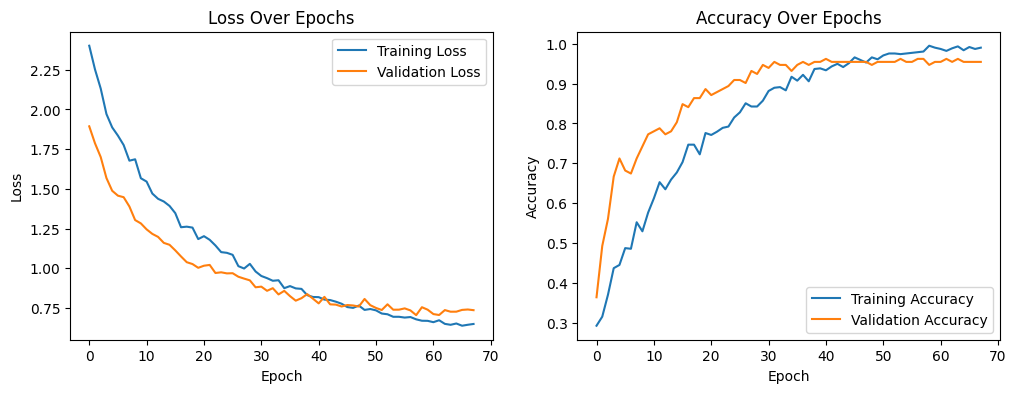

In [12]:
plt.figure(figsize=(12, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.show()

In [13]:
import numpy as np
from sklearn.metrics import precision_score, f1_score, classification_report

# Get predictions on the test dataset
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=-1)

# Extract true labels from test_ds
y_true = np.concatenate([y for x, y in test_ds], axis=0)

print("Classification Report:")
print(classification_report(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_true, y_pred, average='weighted'))

5/5 [==============================] - 1s 77ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        34
           1       0.94      0.97      0.95        32
           2       1.00      0.93      0.96        28
           3       0.97      1.00      0.99        38

    accuracy                           0.97       132
   macro avg       0.97      0.97      0.97       132
weighted avg       0.97      0.97      0.97       132

Precision: 0.9703503567139931
F1 Score: 0.9696404044888893


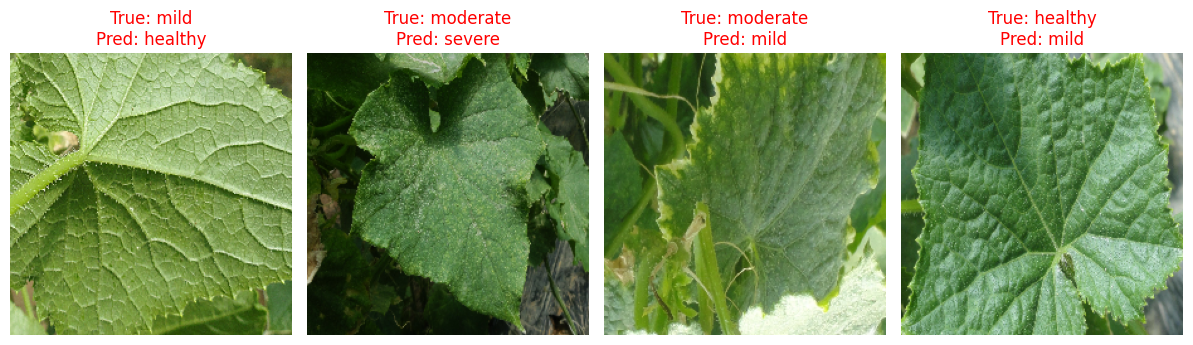

In [15]:
if 'class_names' not in globals():
    class_names = sorted(os.listdir(data_dir))

misclassified_images = []
true_labels = []
pred_labels = []

for batch_images, batch_labels in test_ds:
    # Get predictions for the batch
    predictions = model.predict(batch_images, verbose=0)
    predicted_labels = np.argmax(predictions, axis=1)

    # Identify misclassified indices
    mismatches = np.where(predicted_labels != batch_labels.numpy())[0]

    for idx in mismatches:
        img = (batch_images[idx].numpy() + 1) / 2  # Convert from [-1, 1] to [0, 1]
        misclassified_images.append(img)
        true_labels.append(class_names[int(batch_labels[idx].numpy())])
        pred_labels.append(class_names[predicted_labels[idx]])

# Plot misclassified images (up to 20 for visualization)
plt.figure(figsize=(15, 15))
num_to_show = min(len(misclassified_images), 20)

for i in range(num_to_show):
    plt.subplot(4, 5, i + 1)  # 4 rows × 5 columns
    plt.imshow(misclassified_images[i])
    plt.title(f"True: {true_labels[i]}\nPred: {pred_labels[i]}", color='red')
    plt.axis("off")

if len(misclassified_images) == 0:
    print("🎉 Great job! No misclassifications in the whole test set!")

plt.tight_layout()
plt.show()



In [ ]:
#print trainable pramters
trainable_params = np.sum([np.prod(v.get_shape()) for v in model.trainable_variables])
print(f"Trainable parameters: {trainable_params / 1e6:.2f}M")  # Convert to millions

Trainable parameters: 1.40M



Confusion Matrix:
[[33  0  0  1]
 [ 1 31  0  0]
 [ 0  1 24  3]
 [ 0  0  0 38]]


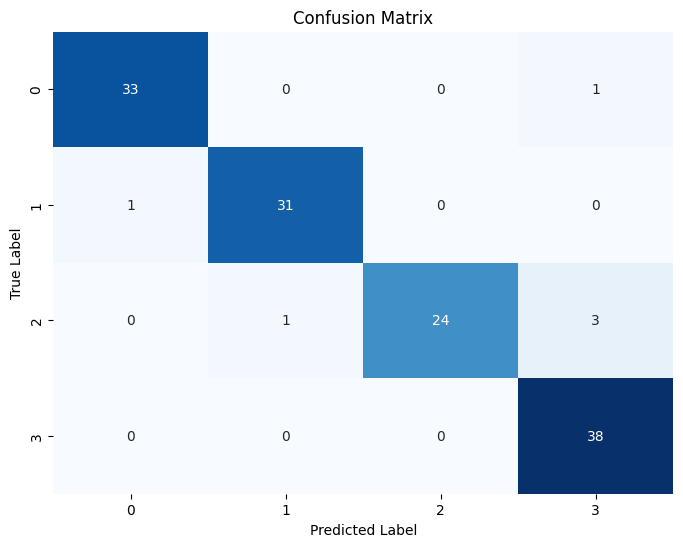

In [ ]:
import seaborn as sns
# Compute confusion matrix using the correct label variables
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.savefig('confusion_matrix.png')

# Print confusion matrix as text
print("\nConfusion Matrix:")
print(cm)

In [18]:
#save model
model.save('classifier_96.97.h5')

In [21]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()
with open('classifier_model.tflite', 'wb') as f:
	 f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmpp2c6frcx\assets


INFO:tensorflow:Assets written to: C:\Users\ACER\AppData\Local\Temp\tmpp2c6frcx\assets
